# AutoRec

In [1]:
import math
import time

from tqdm import tqdm

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, TensorDataset

import matplotlib.pyplot as plt
%matplotlib inline

## Load data

In [2]:
df_train = pd.read_csv('Train.csv')
df_random = pd.read_csv('RandomTest.csv')
df_popular = pd.read_csv('PopularityTest.csv')

In [3]:
df_train.head()

,UserID,ItemID
0,1963,2102
1,1963,1156
2,1963,2555
3,1963,734
4,1963,307


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 988129 entries, 0 to 988128
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   UserID  988129 non-null  int64
 1   ItemID  988129 non-null  int64
dtypes: int64(2)
memory usage: 15.1 MB


## Encode user and item IDs

In [5]:
def generate_encode_maps_for_ids(ids):
    '''
    Convert original IDs to a unique index starting from 0    
    '''
    item_to_index = {}
    index_to_item = {}

    current_item_index = 0
    for item in ids:
        item_to_index[item] = current_item_index
        index_to_item[current_item_index] = item

        current_item_index += 1
        
    return item_to_index, index_to_item

### Generate encoding maps

Generate encoding maps for users and items

In [6]:
# Generate encoding maps for the users
users = df_train['UserID'].unique()
user_to_index, index_to_user = generate_encode_maps_for_ids(users)

In [7]:
# Generate encoding maps for the items
items = df_train['ItemID'].unique()
item_to_index, index_to_item = generate_encode_maps_for_ids(items)

### Encode IDs

Apply encoding maps to user and item columns to generate the new UserID_Encoded and ItemID_Encoded columns

In [8]:
df_train['UserID_Encoded'] = df_train['UserID'].map(user_to_index)

In [9]:
df_train['ItemID_Encoded'] = df_train['ItemID'].map(item_to_index)

In [10]:
df_train.head()

,UserID,ItemID,UserID_Encoded,ItemID_Encoded
0,1963,2102,0,0
1,1963,1156,0,1
2,1963,2555,0,2
3,1963,734,0,3
4,1963,307,0,4


## Generate User-Item vectors

Generate a vector for each user containing 1s for the items they have purchased, and 0s everywhere else. This will result in a sparse vector.

In [12]:
user_vectors = []

# Get all user encoded ids to iterate over them
users_encoded = df_train['UserID_Encoded'].unique()

# This is the number of items we have in our training data
num_items = df_train['ItemID'].nunique()

# Generate the one-hot vector for each user
for user in users_encoded:    
    df_user_items = df_train[df_train['UserID_Encoded'] == user]
    user_items = df_user_items['ItemID_Encoded'].values
    
    # Start by generating a big zeroed vector
    user_vector = np.zeros((num_items))
    # And put ones in every item the user has already purchased
    for item in user_items:
        user_vector[item] = 1
        
    user_vectors.append(user_vector)

user_vectors = np.array(user_vectors)

In [13]:
user_vectors.shape

(6040, 3705)

### Train/validation split

Split the data in train and validation sets. The ratios are 80% of the data for training and 20% for validating.

In [53]:
# Generate indices to split on
indices = range(len(user_vectors))
train_indices, validation_indices = train_test_split(indices, test_size=0.2, shuffle=True, random_state=42)

In [54]:
len(train_indices), len(validation_indices)

(4832, 1208)

In [56]:
# Split user vectors into train and validation
train_items = user_vectors[train_indices]
validation_items = user_vectors[validation_indices]

train_items.shape, validation_items.shape

((4832, 3705), (1208, 3705))

## Create PyTorch dataset and dataloader

Creating a dataset and dataloader to feed data to PyTorch model in a convenient way, with batches and shuffling managed behind the scene for us.

In [17]:
class ItemDataset(Dataset):
    '''
    Custom dataset to hold our item vector data
    '''
    def __init__(self, item_vectors):
        self.items = item_vectors.astype(np.float32)
    
    def __len__(self):
        return len(self.items)
    
    def __getitem__(self, idx):
        return self.items[idx]

In [18]:
def create_dataloader(items_data, shuffle):
    '''
    Generate a dataloader from the input vector data
    '''
    # Create a dataset with the input data
    dataset = ItemDataset(items_data)
    
    # Create a dataloader from the dataset above to manage automatic batching and shuffling
    dataloader = DataLoader(dataset, batch_size=32, shuffle=shuffle)
    
    return dataloader

In [19]:
train_dataloader = create_dataloader(train_items, shuffle=True)

In [20]:
validation_dataloader = create_dataloader(validation_items, shuffle=False)

## Define AutoRec Model

Creating a PyTorch device so the training/inference code will use a GPU is available, else it will run using the CPU.

In [21]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Here is the AutoRec model definition.

In [22]:
class AutoRec(nn.Module):
    def __init__(self, num_items, hidden_size, corruption_percentage):
        super().__init__()
        
        self.dropout = nn.Dropout(corruption_percentage)
        self.encoder = nn.Linear(num_items, hidden_size)
        self.decoder = nn.Linear(hidden_size, num_items)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, items):
        # Corrupt items vector using dropout
        corrupted_items = self.dropout(items)
        
        # Encode corrupted items vector by using a linear layer and applying
        # a sigmoid non-linearity
        encoded_items = self.encoder(corrupted_items)
        encoded_items = self.sigmoid(encoded_items)
        
        # Decode the latent vector generated by the encoder to a vector
        # of all items (same size as the input vector). Our intent is
        # for the model to reconstruct the original vector
        decoded_items = self.decoder(encoded_items)
        
        return decoded_items

In [23]:
model = AutoRec(num_items=num_items,
                hidden_size=50,
                corruption_percentage=0.5)

In [24]:
model.to(device)

AutoRec(
  (dropout): Dropout(p=0.5, inplace=False)
  (encoder): Linear(in_features=3705, out_features=50, bias=True)
  (decoder): Linear(in_features=50, out_features=3705, bias=True)
  (sigmoid): Sigmoid()
)

In [25]:
def masked_loss(outputs, items):
    '''
    Penalize only items that have been purchased. It's basically a RMSE error
    masked to be applied only in the real item purchases.
    '''
    loss = torch.sum( torch.mul((outputs - items), items) ** 2 )
    return loss

In [26]:
def evaluate(model, dataloader, criterion):
    '''
    Evaluate the model on the dataloader provided
    '''
    # Put model in evaluation mode
    model.eval()

    epoch_loss = 0

    # Make sure no gradients are being calculated here, as we are doing evaluation
    with torch.no_grad():
        for _, items in enumerate(dataloader):
            # Move data to device
            items = items.to(device)

            # Generate predictions
            outputs = model(items)

            # Apply our loss function
            loss = masked_loss(outputs, items)

            # Accumulate loss. Using loss.item() to detach the loss vector from PyTorch, so
            # it will not try to get track of further manipulations made to this variable
            epoch_loss += loss.item()

    return epoch_loss / len(dataloader)

In [27]:
def train_step(model, dataloader, optimizer, criterion):
    '''
    One training step of the model.
    '''
    # Put model in training mode
    model.train()

    epoch_loss = 0

    dataiter = iter(dataloader)
    for i in tqdm(range(len(dataloader))):
        # Get a batch of data
        items = next(dataiter)
        
        # Move data to device
        items = items.to(device)

        # Zero in gradient from last epoch values
        optimizer.zero_grad()

        # Generate predictions
        outputs = model(items)
        
        # Apply our loss function
        loss = masked_loss(outputs, items)

        # Backpropagation
        loss.backward()
        
        # Advance optimizer
        optimizer.step()

        # Accumulate loss. Using loss.item() to detach the loss vector from PyTorch, so
        # it will not try to get track of further manipulations made to this variable
        epoch_loss += loss.item()

    return epoch_loss / len(dataloader)

In [28]:
def train_model(model, trainloader, validationloader, epochs=2, learning_rate=1e-3, l2_regularization=0, verbose=1):

    print("Training started...")
    training_start = time.time()

    # Put model in training mode
    model.train()

    # We will use AdamW as our optimizer, with L2 regularization
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=l2_regularization)

    # Our loss metrics will be mean squared error
    criterion = torch.nn.MSELoss()

    losses = []
    val_losses = []

    for epoch in range(epochs):
        epoch_start = time.time()

        train_loss = train_step(model, trainloader, optimizer, criterion)
        print(f'epoch {epoch} loss {train_loss}')

        if (verbose):
            val_loss = evaluate(model, validationloader, criterion)

            epoch_end = time.time()
            epoch_time = epoch_end - epoch_start
            print(f'epoch {epoch} loss {train_loss} val_loss {val_loss} time {epoch_time}s.')

            losses.append(train_loss)
            val_losses.append(val_loss)


    training_end = time.time()
    elapsed_time = training_end - training_start
    print(f"Training completed. Total training time {elapsed_time}s.")

    history = {'loss': losses, 'val_loss': val_losses}

    return history

Train the model.

In [29]:
history = train_model(model, train_dataloader, validation_dataloader, epochs=20, learning_rate=1e-3, l2_regularization=0.1, verbose=1)    

  1%|█                                                                                                                                                                 | 1/151 [00:00<00:30,  4.90it/s]

Training started...


 41%|█████████████████████████████████████████████████████████████████▋                                                                                              | 62/151 [00:00<00:00, 620.00it/s]

epoch 0 loss 686.0174357433193
epoch 0 loss 686.0174357433193 val_loss 26.923400427165785 time 0.480010986328125s.


 32%|███████████████████████████████████████████████████▉                                                                                                            | 49/151 [00:00<00:00, 490.00it/s]

epoch 1 loss 18.438293943341993
epoch 1 loss 18.438293943341993 val_loss 11.116118330704538 time 0.2799997329711914s.


 44%|█████████████████████████████████████████████████████████████████████▉                                                                                          | 66/151 [00:00<00:00, 647.06it/s]

epoch 2 loss 8.655705439333884
epoch 2 loss 8.655705439333884 val_loss 6.558412652266653 time 0.2950010299682617s.


 42%|███████████████████████████████████████████████████████████████████▊                                                                                            | 64/151 [00:00<00:00, 639.93it/s]

epoch 3 loss 5.531576322403964
epoch 3 loss 5.531576322403964 val_loss 4.322536299103184 time 0.26799869537353516s.


 40%|████████████████████████████████████████████████████████████████▋                                                                                               | 61/151 [00:00<00:00, 603.98it/s]

epoch 4 loss 4.011001196918109
epoch 4 loss 4.011001196918109 val_loss 3.570746290056329 time 0.2720003128051758s.


 41%|█████████████████████████████████████████████████████████████████▋                                                                                              | 62/151 [00:00<00:00, 619.94it/s]

epoch 5 loss 3.102381856236237
epoch 5 loss 3.102381856236237 val_loss 3.1348762731803093 time 0.2760050296783447s.


 42%|██████████████████████████████████████████████████████████████████▊                                                                                             | 63/151 [00:00<00:00, 617.65it/s]

epoch 6 loss 2.640834628351477
epoch 6 loss 2.640834628351477 val_loss 2.5744840502738953 time 0.2739889621734619s.


 38%|████████████████████████████████████████████████████████████▍                                                                                                   | 57/151 [00:00<00:00, 564.29it/s]

epoch 7 loss 2.1023209505523277
epoch 7 loss 2.1023209505523277 val_loss 2.2478205875346533 time 0.3130016326904297s.


 41%|█████████████████████████████████████████████████████████████████▋                                                                                              | 62/151 [00:00<00:00, 613.87it/s]

epoch 8 loss 1.6766518760990623
epoch 8 loss 1.6766518760990623 val_loss 1.949275386960883 time 0.29200029373168945s.


 42%|███████████████████████████████████████████████████████████████████▊                                                                                            | 64/151 [00:00<00:00, 633.60it/s]

epoch 9 loss 1.520526820460692
epoch 9 loss 1.520526820460692 val_loss 1.8925616207875704 time 0.28098559379577637s.


 42%|███████████████████████████████████████████████████████████████████▊                                                                                            | 64/151 [00:00<00:00, 633.65it/s]

epoch 10 loss 1.2706254207535295
epoch 10 loss 1.2706254207535295 val_loss 1.7187249597750212 time 0.2740001678466797s.


 43%|████████████████████████████████████████████████████████████████████▊                                                                                           | 65/151 [00:00<00:00, 637.25it/s]

epoch 11 loss 1.1468921272170465
epoch 11 loss 1.1468921272170465 val_loss 1.6993204935600883 time 0.2710111141204834s.


 43%|████████████████████████████████████████████████████████████████████▊                                                                                           | 65/151 [00:00<00:00, 643.50it/s]

epoch 12 loss 1.0084150919061623
epoch 12 loss 1.0084150919061623 val_loss 1.4561334769976766 time 0.26599836349487305s.


 38%|█████████████████████████████████████████████████████████████▍                                                                                                  | 58/151 [00:00<00:00, 568.64it/s]

epoch 13 loss 0.8735693081325253
epoch 13 loss 0.8735693081325253 val_loss 1.359532352340849 time 0.2670018672943115s.


 38%|████████████████████████████████████████████████████████████▍                                                                                                   | 57/151 [00:00<00:00, 569.94it/s]

epoch 14 loss 0.7776791593491637
epoch 14 loss 0.7776791593491637 val_loss 1.303323089292175 time 0.28000569343566895s.


 43%|████████████████████████████████████████████████████████████████████▊                                                                                           | 65/151 [00:00<00:00, 643.57it/s]

epoch 15 loss 0.6787267408228868
epoch 15 loss 0.6787267408228868 val_loss 1.227608524655041 time 0.28100085258483887s.


 43%|████████████████████████████████████████████████████████████████████▊                                                                                           | 65/151 [00:00<00:00, 649.94it/s]

epoch 16 loss 0.6659731924139112
epoch 16 loss 0.6659731924139112 val_loss 1.3468614620597739 time 0.2669990062713623s.


 43%|████████████████████████████████████████████████████████████████████▊                                                                                           | 65/151 [00:00<00:00, 649.97it/s]

epoch 17 loss 0.6528004378277734
epoch 17 loss 0.6528004378277734 val_loss 1.2360516637563705 time 0.2689981460571289s.


 43%|████████████████████████████████████████████████████████████████████▊                                                                                           | 65/151 [00:00<00:00, 637.32it/s]

epoch 18 loss 0.5462619704718621
epoch 18 loss 0.5462619704718621 val_loss 1.1594581368722414 time 0.2690012454986572s.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 151/151 [00:00<00:00, 629.16it/s]

epoch 19 loss 0.5892920495066422
epoch 19 loss 0.5892920495066422 val_loss 1.1641228159791546 time 0.27100038528442383s.
Training completed. Total training time 5.75301194190979s.


Visualize training curves.

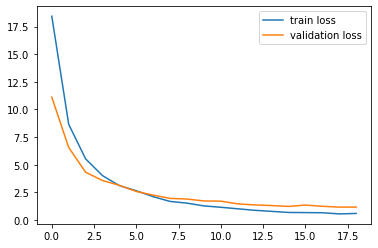

In [30]:
# Loss from first epoch is so high that it will make the plots very hard to analyze, because
# The curve will look very flat. So we will plot loss from epoch 2 onwards instead.
plt.plot(history['loss'][1:], label='train loss')
plt.plot(history['val_loss'][1:], label='validation loss')
plt.legend()
plt.show()

## Predict classifications on test datasets

### Random sampled test dataset

In [31]:
df_random.head()

,UserID,Item1,Item2
0,1963,987,1436
1,5951,1080,872
2,1254,90,192
3,2738,3003,1945
4,3527,351,2744


In [32]:
df_random.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   UserID  6040 non-null   int64
 1   Item1   6040 non-null   int64
 2   Item2   6040 non-null   int64
dtypes: int64(3)
memory usage: 141.7 KB


#### Encode user and item IDs

In [33]:
df_random['UserID_Encoded'] = df_random['UserID'].map(user_to_index)

df_random['Item1_Encoded'] = df_random['Item1'].map(item_to_index)
df_random['Item2_Encoded'] = df_random['Item2'].map(item_to_index)

In [34]:
df_random.head()

,UserID,Item1,Item2,UserID_Encoded,Item1_Encoded,Item2_Encoded
0,1963,987,1436,0,2461.0,1125.0
1,5951,1080,872,1,1529.0,297.0
2,1254,90,192,2,1433.0,761.0
3,2738,3003,1945,3,774.0,3319.0
4,3527,351,2744,4,3158.0,750.0


We can observe that there is 1 item in Item1 column and another in Item2 column that did not appear on the training datasets, so the encoder mapping does not have an entry for them.

In [35]:
df_random.isnull().sum()

UserID            0
Item1             0
Item2             0
UserID_Encoded    0
Item1_Encoded     1
Item2_Encoded     1
dtype: int64

In [36]:
df_random[df_random['Item1_Encoded'].isnull()]

,UserID,Item1,Item2,UserID_Encoded,Item1_Encoded,Item2_Encoded
4163,2014,1750,2068,4163,NaN,1241.0


In [37]:
df_random[df_random['Item2_Encoded'].isnull()]

,UserID,Item1,Item2,UserID_Encoded,Item1_Encoded,Item2_Encoded
2121,5798,3224,1750,2121,171.0,NaN


#### Generate the classification

In [38]:
def generate_item_classification(model, dataframe, user_vectors):
    model.eval()

    outputs = []

    # Each row contains a user, so iterating through all users here
    for row in dataframe.iterrows():
        row = row[1]
        user = int(row['UserID_Encoded'])
        item1 = row['Item1_Encoded']
        item2 = row['Item2_Encoded']

        # If item did not appear in our items vector, we don't have an encoding for it,
        # so just assume user did consume the other item, and continue with the next user
        if math.isnan(item1):
            output = 1
            outputs.append(output)
            continue
        elif math.isnan(item2):
            output = 0
            outputs.append(output)
            continue

        item1 = int(item1)
        item2 = int(item2)

        user_vector = user_vectors[int(user)]

        with torch.no_grad():
            # Create a tensor from the vector data, and move it to the right device
            x_tensor = torch.Tensor(user_vector).to(device)
            
            # Generate predictions, move them to CPU and convert to numpy array
            predictions = model(x_tensor).cpu().numpy()
            
            # Compare probabilities for each item
            item1_probability = predictions[item1]
            item2_probability =predictions[item2]
            
            # The highest probability will be the item we think the user did consume
            output = 0 if item1_probability > item2_probability else 1
            
            outputs.append(output)
            
    outputs = np.array(outputs)
    
    # Create a new dataset with the new column
    df_out = dataframe.copy()
    df_out['bitClassification'] = outputs
    
    return df_out

In [39]:
df_random_classified = generate_item_classification(model, df_random, user_vectors)

In [40]:
df_random_classified.head()

,UserID,Item1,Item2,UserID_Encoded,Item1_Encoded,Item2_Encoded,bitClassification
0,1963,987,1436,0,2461.0,1125.0,1
1,5951,1080,872,1,1529.0,297.0,1
2,1254,90,192,2,1433.0,761.0,1
3,2738,3003,1945,3,774.0,3319.0,0
4,3527,351,2744,4,3158.0,750.0,0


#### Remove undesired columns

In [41]:
df_random_classified = df_random_classified.drop(['UserID_Encoded', 'Item1_Encoded', 'Item2_Encoded'], axis=1)

In [42]:
df_random_classified.head(10)

,UserID,Item1,Item2,bitClassification
0,1963,987,1436,1
1,5951,1080,872,1
2,1254,90,192,1
3,2738,3003,1945,0
4,3527,351,2744,0
5,1169,2758,2652,1
6,3496,466,423,0
7,1684,319,219,0
8,2968,1179,3128,0
9,657,127,1761,1


#### Save to disk

In [43]:
df_random_classified.to_csv('df_random_classified.csv', index=False)

### Popularity-based sampled dataset

In [44]:
df_popular.head()

,UserID,Item1,Item2
0,1963,1503,2798
1,5951,1098,1511
2,1254,366,3523
3,2738,1546,197
4,3527,406,3527


In [45]:
df_popular.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   UserID  6040 non-null   int64
 1   Item1   6040 non-null   int64
 2   Item2   6040 non-null   int64
dtypes: int64(3)
memory usage: 141.7 KB


#### Encoder user and item IDs

In [46]:
df_popular['UserID_Encoded'] = df_popular['UserID'].map(user_to_index)

df_popular['Item1_Encoded'] = df_popular['Item1'].map(item_to_index)
df_popular['Item2_Encoded'] = df_popular['Item2'].map(item_to_index)

In [47]:
df_popular.isnull().sum()

UserID            0
Item1             0
Item2             0
UserID_Encoded    0
Item1_Encoded     1
Item2_Encoded     0
dtype: int64

#### Generate classifications

In [48]:
df_popular_classified = generate_item_classification(model, df_popular, user_vectors)

In [49]:
df_popular_classified.head()

,UserID,Item1,Item2,UserID_Encoded,Item1_Encoded,Item2_Encoded,bitClassification
0,1963,1503,2798,0,144.0,2133,0
1,5951,1098,1511,1,863.0,598,0
2,1254,366,3523,2,693.0,110,0
3,2738,1546,197,3,72.0,61,0
4,3527,406,3527,4,101.0,557,1


#### Remove undesired columns

In [50]:
df_popular_classified = df_popular_classified.drop(['UserID_Encoded', 'Item1_Encoded', 'Item2_Encoded'], axis=1)

In [51]:
df_popular_classified.head(10)

,UserID,Item1,Item2,bitClassification
0,1963,1503,2798,0
1,5951,1098,1511,0
2,1254,366,3523,0
3,2738,1546,197,0
4,3527,406,3527,1
5,1169,2409,1264,0
6,3496,3666,500,1
7,1684,109,848,1
8,2968,1568,531,0
9,657,1642,2446,0


#### Save to disk

In [52]:
df_popular_classified.to_csv('df_popular_classified.csv', index=False)